This project creates a model that classifies handwritten 3s and 7s from the MNIST sample dataset.

In [1]:
!pip install -Uqq fastai

In [2]:
from fastai.vision.all import *

matplotlib.rc('image', cmap='Greys')

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

In [4]:
Path.BASE_PATH = path

In [5]:
path

Path('.')

We check what's in path:

In [6]:
path.ls()

(#3) [Path('train'),Path('labels.csv'),Path('valid')]

Checking the train folder:

In [7]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

We can sort the training data:

In [8]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

In [9]:
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [10]:
sevens

(#6265) [Path('train/7/10002.png'),Path('train/7/1001.png'),Path('train/7/10014.png'),Path('train/7/10019.png'),Path('train/7/10039.png'),Path('train/7/10046.png'),Path('train/7/10050.png'),Path('train/7/10063.png'),Path('train/7/10077.png'),Path('train/7/10086.png')...]

Taking a look at one image from the 3s folder:

In [11]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [12]:
type(im3)

PIL.PngImagePlugin.PngImageFile

We need to represent this in number format as everything is represented as numbers in computers.
To view the number that represent this image we convert it to a Numpy array or PyTorch tensor.


To convert it to a Numpy array:

In [13]:
array(im3)[4:10, 4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

To convert to a PyTorch Tensor:

In [14]:
tensor(im3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [15]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15, 4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


## Creating a model that detects a 3

#### Pixel Similarity  
- Find the average pixel value for every pixel; of the threes and sevens.  
- The two group averages define the "ideal" 3 and 7.  
- Then to classify an image as a digit, we see which of these two ideal digits the image is similar to.

##### Create a baseline model

First, we need to list all the images of sevens and threes as tensors.

In [16]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)

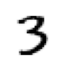

In [17]:
show_image(three_tensors[1]);

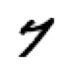

In [18]:
show_image(seven_tensors[1]);

In [19]:
type(seven_tensors)

list

We now need to get the average of all those 3s and 7s.  
First we need to change three_tensors and seven_tensors from lists, which can't easily do mathematical computations.

In [20]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

This stacks up all the 28×28 pixels images on top of each other.

In [21]:
len(stacked_threes.shape)

3

This gives us a Rank 3 tensor.

We can also get it from 'ndim' that stands for number of dimensions.

In [22]:
stacked_threes.ndim

3

Getting the mean for 3 and 7:

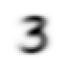

In [23]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

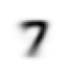

In [24]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

This shows us the ideal 3 and 7.

Now, let's grab a 3:

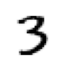

In [25]:
a_3 = stacked_threes[1]
show_image(a_3);

We can find if the a_3 is similar to the 'ideal' 3 or 7.  
The one that is more similar to, that's the answer.

This can be achieved by:  
1) Finding the absolute values (simply means removing the minus sign), the take the average. This is called the Mean Absolute Difference or L1 norm.  
2) Take the square of each difference and the take the mean then find the square root to undo the squaring. This is called Root Mean Squared Error or L2 norm.|

In [26]:
dist_3_abs = (a_3-mean3).abs().mean()
dist_3_sqr = ((a_3-mean3)**2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [27]:
dist_7_abs = (a_3-mean7).abs().mean()
dist_7_sqr = ((a_3-mean7)**2).mean().sqrt()
dist_7_abs, dist_7_sqr

(tensor(0.1586), tensor(0.3021))

The distance in terms of absolute from mean of 3 is 0.114 and mean of 7 is 0.1586 so its close to the mean of 3 than the mean of 7. Therefore, we can guess that its a 3 based on the mean absolute differences.  
This is same for the root mean squared error.

PyTorch already provides both of these as loss functions. You'll find these inside torch.nn.functional, which the PyTorch team recommends importing as F.  
mse stands for mean squared error, and l1 refers to the standard mathematical jargon for mean absolute value.

In [28]:
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

## Computing metrics using broadcasting

Metric -> a number which is calculated from the predictions of our model and the correct labels in our dataset, in order to tell us how good our model is.

First, lets create a tensor of our threes and sevens from our valid directory.

In [29]:
valid_3_tens = torch.stack([tensor(Image.open(o))
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o))
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

Let's create a function that takes the difference between two things, takes the absolute value and then takes the mean.

In [30]:
def mnist_distance(a, b): return (a-b).abs().mean((-1, -2))
mnist_distance(a_3, mean3)

tensor(0.1114)

We need to do this for every image in the validation set so as to find the overall metric.

In [31]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1328, 0.1523, 0.1245,  ..., 0.1383, 0.1280, 0.1138]),
 torch.Size([1010]))

In [32]:
valid_3_tens.shape

torch.Size([1010, 28, 28])

In [33]:
mean3.shape

torch.Size([28, 28])

(valid_3_tens - mean3).shape

Broadcasting is used when carrying out mathematical operations of different rank tensors.

In this case, we have different shapes. Broadcasting ends up doing is copying mean3 1010 times and acts as if we had valid_3_tens minus 1010 copies of mean3.

We can now create is_3 function:

In [34]:
def is_3(x): return mnist_distance(x, mean3) < mnist_distance(x,mean7)

Let's check with a_3:

In [35]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

Using broadcating, we can check the whole validation dataset.

In [36]:
is_3(valid_3_tens)

tensor([ True,  True,  True,  ..., False,  True,  True])

Now, we can calculate the accuracy of the threes and sevens by taking the average of the function for all 3s and 7s.

In [37]:
accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = 1 - is_3(valid_7_tens).float().mean()
accuracy_3s, accuracy_7s, (accuracy_3s + accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

Accuracy is 91% for 3s, 98% for 7s and 95% for both.   
This is a good baseline.

## Gradient Descent

So here are the steps that we are going to require, to turn this function into a machine learning classifier:  
1) We will start with a vector w(A vector is a Rank 1 tensor) containing random weights/parameters.  
2) Then, we will predict whether the number is a 3 or 7.  
3) Based on the predictions, calculate how good the model is (its loss).  
4) Key step -> Calculate the gradient, which measure for each weight, how  changing that weight would change the loss.  
5) Step/Change all the weights based on that calculation.  
6) Go back to step 2 and repeat the process.  
7) ... repeat until you decide to stop the training process (for instance because the model is good enough).  

These steps are called Gradient Descent

We need a loss function that represents how good our model is.  
From the loss function, we can calculate our gradient.

We have x, the images. We'll concatenate them all into a single tensor and also change then from a list of matrices (Rank3 tensor) to a list of vectors (Rank2 tensor).  
This can be achieved by view, a Pytorch method that changes the shape of a tensor without changing its contents.

In [38]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

Now we need labels.  
Our labels will be 1 for each of the 3s and 0 for each of the 7s. This is basically a "is_3" model. This will create a vector and we need it to be matrix in PyTorch.

In [39]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

Now we turn our x and y into a Dataset.  
Python provides a zip function which when combined with list, provides a simple way to get this functionality.

In [40]:
dset = list(zip(train_x, train_y))
x, y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

Repeat the same step for the validation set:

In [41]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))

Now we will start our 7 step process.

1) Initialize our parameters

In [42]:
def init_params(size, std=1.0): return(torch.randn(size)*std).requires_grad_()

In [43]:
weights = init_params((28*28), 1)

Initializing a random number for bias:

In [44]:
bias = init_params(1)

2) Calculate the predictions

For one image:

In [45]:
(train_x[0] * weights.T).sum() + bias

/tmp/ipykernel_2407/4052062786.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2981.)
  (train_x[0] * weights.T).sum() + bias


tensor([8.9636], grad_fn=<AddBackward0>)

We want to do that for every image.  
We could us a for loop but it will be every slow and Python loops don't run on GPUs.  
For this reason, a matrix multiplication is the best as it calculates w*x for every row of a matrix.  
In Python, matrix multiplication is represented by the @ operator.

In [46]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([ 8.9636,  6.2432, 14.4787,  ...,  8.8288,  9.9224,  2.9911],
       grad_fn=<AddBackward0>)

3) Check our accuracy

We can decide that anything greater than 0 we will call it a 3, and anything less than a 0 we call it a 7.  
So preds greater than 0.0 tells us whether or not something is predicted to be 3 or not. Then, we turn it to a float(1 or 0) because that's what our training set contains.  
Then we check whether our thresholded predictions are equal to our training set.  
This will return true when predicted correctly and false otherwise.

In [47]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

Turning then into floats:

In [48]:
corrects.float().mean().item()

0.4955900311470032

4) Change the derivatives

Let's change the weight by small bits:

In [49]:
with torch.no_grad(): weights[0] *= 1.0001

In [50]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.4955900311470032

Even after changing the weights, pred is still the same. This means that our gradient is 0 therefore  our step/change is 0 and our prediction will not change.  
Therefore, we need to use another thing other than accuracy as our loss function.

Let's try find a loss function that measures the distance between predictions and targets:  


##### Sigmoid function  
We will apply a sigmoid function.  
Sigmoid function works like this: if you pass a small number, e.g -4, you get a number close to 0, and if you pass a big number you get a number close to 1 but never past 1.
In the middle, the curve looks like a y=x line.  
Sigmoid can be defined by:  


In [51]:
# def sigmoid(x): return 1/(1 + torch.exp(-x))

The mnist loss function with a sigmoid function looks like:

In [52]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

##### SGD and Mini-batches
We need to create minibatches where we'll:  
- Looping through   
- calculate a prediction of the images in the minibatch 
- calculate a loss then  
- step the parameters  
- do that for other images in the minibatches  

We will use a DataLoader to shuffle and minibatch collation. A DataLoader can take any Python collection and turn it into an iterator over mini-batches. A DataLoader can be created from a Dataset:

In [53]:
dl = DataLoader(dset, batch_size=256)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

We'll do the same for the validation set:

In [54]:
valid_dl = DataLoader(valid_dset, batch_size=256)

Let's create a mini-batch of size 4 for testing:

In [55]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

We pass the batch into a linear function that we created earlier:

In [56]:
preds=linear1(batch)
preds

tensor([ 8.9636,  6.2432, 14.4787, 10.1211], grad_fn=<AddBackward0>)

We can calculate the loss using the loss function we just used and let's grab the first 4 items of the training set:

In [57]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.0005, grad_fn=<MeanBackward0>)

Now we can calculate the gradient:

In [58]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784]), tensor(-7.5269e-05), tensor([-0.0005]))

Putting these step in a function:

In [59]:
def calc_grad(xb, yb, model):     #pass the x batch, y batch and model  
    preds = model(xb)             #calculate predictions  
    loss = mnist_loss(preds, yb)  #calculate loss  
    loss.backward()               #do backward step

Test it:

In [60]:
calc_grad(batch, train_y[:4], linear1)   #calculate gradient  
weights.grad.mean(), bias.grad

(tensor(-0.0002), tensor([-0.0011]))

Call it a second time:

In [61]:
calc_grad(batch, train_y[:4], linear1)   #calculate gradient  
weights.grad.mean(), bias.grad

(tensor(-0.0002), tensor([-0.0016]))

Here, we get a different value because loss.backward() calculates the gradient and adds them to the existing gradients (In the .grad attribute).
What we need to do is call grad.zero_()

In [62]:
weights.grad.zero_()
bias.grad.zero_()

tensor([0.])

Now we train one epoch with SGD:

In [63]:
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

We also want to check how we're doing, by looking at the accuracy of the validation set. To decide if an output represents a 3 or a 7, we can just check whether it's greater than 0. So our accuracy for each item can be calculated (using broadcasting, so no loops!) with:

In [64]:
(preds>0.0).float() == train_y[:4]

tensor([[True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True]])

That gives us this function to calculate our validation accuracy:

In [65]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds > 0.5) ==yb
    return correct.float().mean()

We can check if it works:

In [66]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(1.)

and then put the batches together:

In [67]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

Here's the validation accuracy:

In [68]:
validate_epoch(linear1)

0.5305

So now we train for one epoch:

In [69]:
lr = 1.
params = weights, bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.607

Now, we repeat it a few times:

In [70]:
for i in range(20):
    train_epoch(linear1,lr,params)
    print(validate_epoch(linear1), end=' ')

0.7932 0.8806 0.9118 0.928 0.9337 0.9379 0.9412 0.9446 0.9465 0.9474 0.9479 0.9493 0.9517 0.9522 0.9527 0.9551 0.9555 0.9569 0.9569 0.9574 

Accuracy has improved.

### Creating an Optimizer

We'll get rid of the linear1 function:

In [71]:
linear1??

Signature: linear1(xb)
Docstring: <no docstring>
Source:    def linear1(xb): return xb@weights + bias
File:      /tmp/ipykernel_2407/3366534937.py
Type:      function


We just create a nn.linear class and that's going to create a matrix of size(28, 28, 1) and bias of size 1. It will set requires_grad = True for us.

In [72]:
linear_model = nn.Linear(28 * 28, 1)

To see the parameters, we would expect it to contain 784 weights and 1 bias, we can just call .parameters():

In [73]:
w, b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

Now, we can create an optimizer:

In [74]:
class BasicOptim:
    def __init__(self, params, lr): self.params, self.lr = list(params), lr
    
    def step(self, *args, **kwargs):
        for p in self.params: p.data -=p.grad.data * self.lr
        
    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

we can pass in the parameters of the linear model and our learning rate:

In [75]:
opt = BasicOptim(linear_model.parameters(), lr)

Now our training loop looks through each of the minibatch in the data loader, calculates the gradient, does the opt.step and opt.zero_grad:

In [76]:
def train_epoch(model):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

Validation function doesn't need to change:

In [77]:
validate_epoch(linear_model)

0.5134

So let's put our training loop into a function:

In [78]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [79]:
train_model(linear_model, 20)

0.4932 0.8691 0.8281 0.9111 0.9335 0.9472 0.955 0.9623 0.9662 0.9677 0.9692 0.9716 0.9736 0.975 0.976 0.9765 0.9775 0.978 0.9785 0.9789 

We don't need to come up with BasicOptim, fastai provides SGD class which does the same:

In [80]:
linear_model = nn.Linear(28*28, 1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.791 0.8515 0.916 0.9355 0.9496 0.9565 0.9638 0.9657 0.9672 0.9697 0.9721 0.9736 0.975 0.976 0.9765 0.9775 0.978 0.978 0.9785 

We can now train a model:

In [81]:
dls = DataLoaders(dl, valid_dl)

In [82]:
learn = Learner(dls, nn.Linear(28*28, 1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

This will call train_model and train_epoch.

Now we can call fit:

In [83]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.637430,0.503588,0.495584,00:00
1,0.569758,0.225416,0.801276,00:00
2,0.208664,0.174973,0.843474,00:00
3,0.090253,0.104066,0.913150,00:00
4,0.046679,0.076577,0.934249,00:00
5,0.029753,0.061667,0.947988,00:00
6,0.022873,0.052298,0.955839,00:00
7,0.019868,0.046026,0.961727,00:00
8,0.018377,0.041603,0.965653,00:00
9,0.017499,0.038334,0.967125,00:00


## Adding Non-Linearity

In [84]:
def simple_net(xb):
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = xb@w2 + b2

A simple net does the following:
- Takes a linear function
- Replaces negatives with 0s
- Takes that and puts it through another linear function

This is a neural network.

Initializing weights and biases:

In [85]:
w1 = init_params((28*28), 30)
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

res = res.max(tensor(0.0)) is called the Rectified Linear Unit(ReLU).  
In PyTorch, it has a function called F.relu. We can plot it:

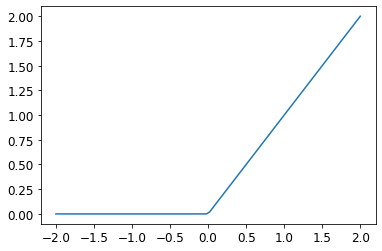

In [87]:
from fastbook import *
plot_function(F.relu)

Simplifying things:

In [88]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30,1)
)